<a href="https://colab.research.google.com/github/sunnyday2/flight_on_time/blob/desarrollo/flightontime_hackaton_e32_alura_latam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# FlightOnTime ✈️ Data Science

## Comportación final de los datasets presentados por miembros del equipo

Esa se basa en los resultados de evaluación previa de cada dataset previamente evaluado:


*   Rafael https://www.kaggle.com/datasets/arvindnagaonkar/flight-delay?select=Flight_Delay.parquet
*   Alex https://www.kaggle.com/datasets/giovamata/airlinedelaycauses/DelayedFlights.csv
*   Anna https://www.kaggle.com/datasets/threnjen/2019-airline-delays-and-cancellations?select=full_data_flightdelay.csv
*   Javier https://www.kaggle.com/datasets/patrickzel/flight-delay-and-cancellation-dataset-2019-2023?select=flights_sample_3m.csv



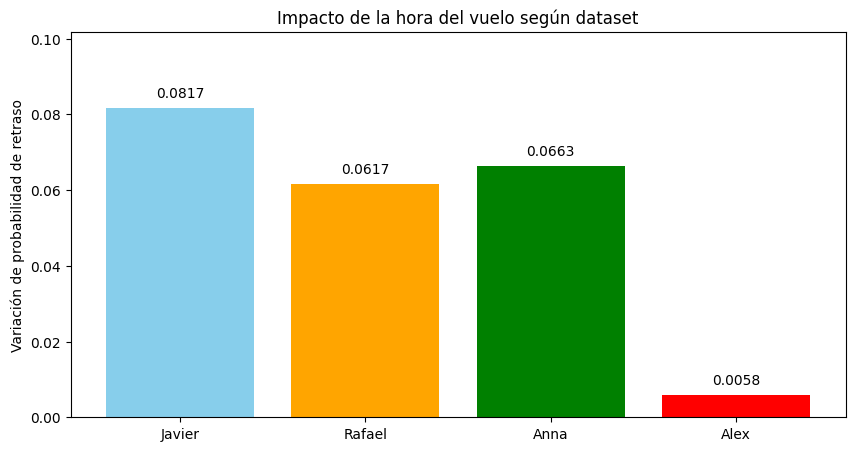

In [1]:
# -*- coding: utf-8 -*-
"""analisis_final_dataset.ipynb

Automatically generated by Colab.

Original file is located at
    https://colab.research.google.com/drive/1NlCHZVZtU_LD4hKFcV36YE4ydFJUDSMJ
"""

# Comparación datasets

# Importamos librerías
import matplotlib.pyplot as plt

# DATOS: Variación de probabilidad de retraso según hora
# Este número mide el "impacto de la hora del vuelo"
nombres = ["Javier", "Rafael", "Anna", "Alex"]
variaciones = [0.08168772635113504, 0.0617, 0.06625976077440347, 0.005829360131785699]

plt.figure(figsize=(10,5))
bars = plt.bar(nombres, variaciones, color=["skyblue", "orange", "green", "red"])
plt.ylabel("Variación de probabilidad de retraso")
plt.title("Impacto de la hora del vuelo según dataset")

# Añadimos los valores exactos encima de cada barra
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.002, round(yval,4), ha='center', va='bottom')

plt.ylim(0, max(variaciones)+0.02)
plt.show()


1. Qué significa "impacto de la hora del vuelo":
   - Es cuánto cambia la probabilidad de retraso según la hora a la que sale el vuelo.
   - Un valor alto significa que la hora importa mucho; un valor bajo significa que importa poco.

2. Qué significan los números:
   - Javier: 0.0817 → la hora tiene mucho efecto, pero es menos consistente.
   - Rafael: 0.0617 → la hora tiene efecto medio, pero es estable y fiable.
   - Anna: 0.0663 → efecto medio, pero no captura todos los patrones.
   - Alex: 0.00583 → la hora casi no afecta los retrasos; el dataset captura muy poca señal horaria.

3. Por qué elegir Rafael:
   - Nos da información clara y consistente sobre cuándo es más probable un retraso.
   - Evita confundirnos con valores ruidosos o inconsistentes.
   - Es como elegir la brújula más fiable: apunta bien aunque no sea el número más alto.

_Rafael nos dice claramente qué horas afectan los retrasos y lo hace de manera consistente, por eso es el dataset más fiable para predecir vuelos retrasados._

### POR QUÉ ES IMPORTANTE QUE EL IMPACTO DE LA HORA SEA BAJO

    El impacto de la hora del vuelo mide cuánto cambia la probabilidad
    de retraso según la hora de salida.

    Un valor muy alto no implica mejor información. Suele indicar problemas de estabilidad.

### **Impacto alto**

    - Grandes cambios de probabilidad según la hora.
    - Puede deberse a ruido o pocos datos.
    - Modelo muy sensible y poco generalizable.

### **Impacto bajo o moderado**

    - La hora influye de forma controlada.
    - Patrón más estable y consistente.
    - Representa mejor la realidad.

### **Impacto muy bajo**

    - La probabilidad de retraso apenas cambia según la hora.
    - La señal horaria es débil o ausente.
    - Modelos que usan este dataset no podrán aprovechar la hora como predictor.
    - Esto hace que el dataset sea poco útil para analizar retrasos por hora.

### **Ventaja principal**

    - Reduce el sobreajuste.
    - Mejora la generalización.
    - Predicciones más fiables.

### **Conclusión**

   ---
  > Un impacto bajo indica un efecto real y estable, haciendo el dataset
    más confiable para predecir retrasos de vuelos. Sin embargo, si el
    impacto es muy bajo, como en Alex, la señal horaria se pierde y
    el dataset deja de ser útil para este criterio.
    Si mi vuelo sale a las 6 am o a las 6 pm, ¿cambia mucho la probabilidad de retraso?

# **1. Carga y Exploración Inicial (Profiling)**

---------

## Descargar el dataset de Rafael para el analisis e entrenamiento

In [2]:
!pip install kagglehub pyarrow requests

In [5]:
import kagglehub
import pandas as pd
import pyarrow.parquet as pq

path = kagglehub.dataset_download("arvindnagaonkar/flight-delay")
print(path)

parquet_file = "/kaggle/input/flight-delay/Flight_Delay.parquet"
n_sample = 100_000   #Limito filas

pf = pq.ParquetFile(parquet_file)  #Abre parte del parquet si cargarse la memoria


Using Colab cache for faster access to the 'flight-delay' dataset.
/kaggle/input/flight-delay


## Cargar dataset por bloques

In [6]:
#loop muestreo. Lee parquet por bloques, junta filas, no carga todo el dataset.
rows = []
rows_read = 0

for batch in pf.iter_batches(batch_size=50_000): #, columns=columns_needed):
    df_batch = batch.to_pandas()
    remaining = n_sample - rows_read
    if remaining <= 0:
        break
    if len(df_batch) > remaining:
        df_batch = df_batch.sample(remaining, random_state=42)
    rows.append(df_batch)
    rows_read += len(df_batch)

#dataframe resultado uniendo batches

df = pd.concat(rows, ignore_index=True)


## **Inspección visual**




### Visualizar las primeras 5 filas.

In [7]:
df.head()

,Year,Month,DayofMonth,FlightDate,Marketing_Airline_Network,OriginCityName,DestCityName,CRSDepTime,DepTime,DepDelay,...,CRSElapsedTime,ActualElapsedTime,AirTime,Distance,DistanceGroup,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
0,2018,1,15,2018-01-15,UA,"Newark, NJ","Charleston, SC",1845,1928.0,43.0,...,143.0,141.0,102.0,628.0,3,41.0,0.0,0.0,0.0,0.0
1,2018,1,16,2018-01-16,UA,"Newark, NJ","Charleston, SC",1835,1956.0,81.0,...,143.0,131.0,108.0,628.0,3,67.0,0.0,0.0,0.0,2.0
2,2018,1,17,2018-01-17,UA,"Newark, NJ","Charleston, SC",1835,1836.0,1.0,...,143.0,138.0,113.0,628.0,3,0.0,0.0,0.0,0.0,0.0
3,2018,1,18,2018-01-18,UA,"Newark, NJ","Charleston, SC",1845,1844.0,-1.0,...,143.0,134.0,92.0,628.0,3,0.0,0.0,0.0,0.0,0.0
4,2018,1,20,2018-01-20,UA,"Newark, NJ","Charleston, SC",1835,1829.0,-6.0,...,143.0,117.0,89.0,628.0,3,0.0,0.0,0.0,0.0,0.0


### **Estructura**

*   Revisar cuántas filas y columnas hay.

In [8]:
print(f"Cantidad de columnas y filas: {df.shape}")

Cantidad de columnas y filas: (100000, 29)


*   Qué tipo de datos contiene cada una (¿son números, fechas, texto?)

In [9]:
df.dtypes

,0
Year,int64
Month,int64
DayofMonth,int64
FlightDate,object
Marketing_Airline_Network,object
OriginCityName,object
DestCityName,object
CRSDepTime,int64
DepTime,float64
DepDelay,float64


### **Estadística básica**

*   Calcular medias, medianas y desviaciones estándar para entender la distribución de los números.

In [10]:
df.describe()

,Year,Month,DayofMonth,CRSDepTime,DepTime,DepDelay,DepDelayMinutes,TaxiOut,WheelsOff,WheelsOn,...,CRSElapsedTime,ActualElapsedTime,AirTime,Distance,DistanceGroup,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
count,100000.0,100000.0,100000.000000,100000.000000,100000.00000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,...,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,2018.0,1.0,14.879780,1327.535980,1335.14702,10.116290,13.661770,15.976660,1358.813680,1467.842620,...,137.979840,130.186510,107.180340,764.650600,3.527760,4.647050,0.703230,2.550650,0.018280,5.256900
std,0.0,0.0,9.050645,487.958328,498.49002,49.230517,48.086319,9.642199,498.267314,521.188453,...,74.304854,72.336005,69.939664,586.343365,2.280382,32.336684,13.665402,15.254682,1.211726,25.825928
min,2018.0,1.0,1.000000,1.000000,1.00000,-45.000000,0.000000,1.000000,1.000000,1.000000,...,18.000000,11.000000,8.000000,16.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2018.0,1.0,7.000000,915.000000,920.00000,-6.000000,0.000000,10.000000,934.000000,1049.000000,...,85.000000,79.000000,58.000000,345.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2018.0,1.0,15.000000,1319.000000,1329.00000,-3.000000,0.000000,14.000000,1342.000000,1506.000000,...,120.000000,113.000000,89.000000,604.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2018.0,1.0,23.000000,1730.000000,1741.00000,4.000000,4.000000,18.000000,1755.000000,1910.000000,...,171.000000,162.000000,137.000000,1005.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,2018.0,1.0,31.000000,2359.000000,2400.00000,1682.000000,1682.000000,157.000000,2400.000000,2400.000000,...,704.000000,712.000000,683.000000,4983.000000,11.000000,1469.000000,1682.000000,1317.000000,264.000000,1342.000000



---

> **Aquí las estadísticas clave que estás viendo**:
>
> - **count (conteo)**: Es el número de observaciones no nulas en cada columna. En este conjunto de datos, todas las columnas numéricas tienen 100,000 entradas, lo que significa que no hay valores faltantes en estas columnas.
>
> - **mean (media)**: Es el valor promedio de cada columna. Por ejemplo, el promedio de `DepDelay` (retraso de salida) es de aproximadamente 10.12 minutos, y la distancia promedio de los vuelos es de alrededor de 764.65 millas.
>
> - **std (desviación estándar)**: Mide la cantidad de variación o dispersión de un conjunto de valores. Una desviación estándar alta indica que los datos están más dispersos, mientras que una baja indica que los datos tienden a estar cerca de la media. Por ejemplo, `DepDelay` tiene una desviación estándar de 49.23, lo que es bastante alto en comparación con su media, sugiriendo que hay una variabilidad significativa en los retrasos de salida.
>
> - **min (mínimo)**: Es el valor mínimo en cada columna. Para `DepDelay`, el mínimo es -45, lo que indica que algunos vuelos salieron 45 minutos antes de lo programado.
>
> - **25% (Q1)**: Es el primer cuartil, lo que significa que el 25% de los datos están por debajo de este valor.
>
> - **50% (Q2)**: Es el segundo cuartil o mediana, que es el valor medio cuando los datos están ordenados. Para `DepDelay`, la mediana es de -3 minutos, lo que implica que al menos la mitad de los vuelos salieron a tiempo o antes.
>
> - **75% (Q3)**: Es el tercer cuartil, lo que significa que el 75% de los datos están por debajo de este valor.
>
> - **max (máximo)**: Es el valor máximo en cada columna. Para `DepDelay`, el máximo es de 1682 minutos, lo que indica que algunos vuelos experimentaron retrasos muy largos.



# **2. Limpieza de Datos (Data Cleaning)**

### **Valores faltantes**

*   ¿Hay celdas vacías? Debes decidir si borras esas filas o rellenas los huecos con la media o un valor lógico.

In [11]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 29 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   Year                       100000 non-null  int64  
 1   Month                      100000 non-null  int64  
 2   DayofMonth                 100000 non-null  int64  
 3   FlightDate                 100000 non-null  object 
 4   Marketing_Airline_Network  100000 non-null  object 
 5   OriginCityName             100000 non-null  object 
 6   DestCityName               100000 non-null  object 
 7   CRSDepTime                 100000 non-null  int64  
 8   DepTime                    100000 non-null  float64
 9   DepDelay                   100000 non-null  float64
 10  DepDelayMinutes            100000 non-null  float64
 11  TaxiOut                    100000 non-null  float64
 12  WheelsOff                  100000 non-null  float64
 13  WheelsOn                   100

---
> Según la salida de `df.info()`, todas las columnas en ese conjunto de datos muestran un conteo de no nulos de 100,000, lo que coincide con el índice de rango total de 100,000 entradas. Esto significa que no hay valores faltantes en este DataFrame. Por lo tanto, no es necesario tomar ninguna medida para eliminar filas o llenar espacios vacíos.

### **Duplicados**

*   Eliminar registros repetidos que puedan sesgar los resultados.

In [12]:
num_duplicates = df.duplicated().sum()
print(f"Número de filas duplicadas: {num_duplicates}")

Número de filas duplicadas: 0


---
> La salida muestra: `"Number of duplicate rows: 0"`. Esto significa que no hay entradas duplicadas en el DataFrame, por lo que no es necesario tomar medidas adicionales para eliminarlas.



### **Formateo**

*  Asegurarse de que las fechas sean tratadas como fechas y no como simple texto.
*  Convertir fecha/hora a datetime.

In [13]:
df['FlightDate'] = pd.to_datetime(df['FlightDate'])
print(df['FlightDate'].dtypes)

datetime64[ns]


---


> La columna `FlightDate` se ha convertido exitosamente al tipo de dato `datetime64[ns]`, lo que significa que está correctamente formateada para cualquier operación o análisis basado en fechas.



# **3. Análisis Exploratorio de Datos (EDA)**

## **Detección de Outliers**

Identificar valores atípicos (por ejemplo, un sueldo de un billón de dólares en una lista de empleados comunes) que podrían arruinar el modelo.

In [14]:
df_numeric = df.select_dtypes(include='number')
print(f"Forma del DataFrame numérico: {df_numeric.shape}")
df_numeric.head()

Forma del DataFrame numérico: (100000, 25)


,Year,Month,DayofMonth,CRSDepTime,DepTime,DepDelay,DepDelayMinutes,TaxiOut,WheelsOff,WheelsOn,...,CRSElapsedTime,ActualElapsedTime,AirTime,Distance,DistanceGroup,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
0,2018,1,15,1845,1928.0,43.0,43.0,35.0,2003.0,2145.0,...,143.0,141.0,102.0,628.0,3,41.0,0.0,0.0,0.0,0.0
1,2018,1,16,1835,1956.0,81.0,81.0,18.0,2014.0,2202.0,...,143.0,131.0,108.0,628.0,3,67.0,0.0,0.0,0.0,2.0
2,2018,1,17,1835,1836.0,1.0,1.0,19.0,1855.0,2048.0,...,143.0,138.0,113.0,628.0,3,0.0,0.0,0.0,0.0,0.0
3,2018,1,18,1845,1844.0,-1.0,0.0,36.0,1920.0,2052.0,...,143.0,134.0,92.0,628.0,3,0.0,0.0,0.0,0.0,0.0
4,2018,1,20,1835,1829.0,-6.0,0.0,22.0,1851.0,2020.0,...,143.0,117.0,89.0,628.0,3,0.0,0.0,0.0,0.0,0.0


## **Contar y mostrar outliers**

*   Contar el número de puntos de datos que están por debajo del límite inferior o por encima del límite superior para cada columna numérica. Mostrar estos conteos para indicar cuántos outliers hay en cada variable.

Para contar el número de outliers en cada columna numérica, itera a través de las columnas en `df_numeric`, aplica los límites inferior y superior definidos para identificar los outliers y almacenaré los conteos en un diccionario.



In [15]:
outlier_counts = {}

# Calculate Q1, Q3, IQR, lower_bound, and upper_bound within this cell
Q1 = df_numeric.quantile(0.25)
Q3 = df_numeric.quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

for column in df_numeric.columns:
    # Skip Year and Month columns as they are constant in this dataset sample
    if column in ['Year', 'Month']:
        continue

    # Count outliers for each column
    num_outliers = df_numeric[(df_numeric[column] < lower_bound[column]) | (df_numeric[column] > upper_bound[column])].shape[0]
    outlier_counts[column] = num_outliers

print("Número de outliers por columna numérica")
print("****************************************\n")
for col, count in outlier_counts.items():
    print(f"{col}: {count}")

Número de outliers por columna numérica
****************************************

DayofMonth: 0
CRSDepTime: 0
DepTime: 0
DepDelay: 16069
DepDelayMinutes: 19637
TaxiOut: 6109
WheelsOff: 0
WheelsOn: 0
TaxiIn: 6129
CRSArrTime: 0
ArrTime: 0
ArrDelay: 16106
ArrDelayMinutes: 20870
CRSElapsedTime: 4373
ActualElapsedTime: 4625
AirTime: 4911
Distance: 5097
DistanceGroup: 3492
CarrierDelay: 11140
WeatherDelay: 1374
NASDelay: 10159
SecurityDelay: 65
LateAircraftDelay: 10522


*   Ahora que se han calculado y mostrado los conteos de outliers, el siguiente paso es visualizar estos outliers para columnas numéricas clave utilizando diagramas de caja. Esto proporcionará una representación gráfica de la distribución y la magnitud de los outliers.

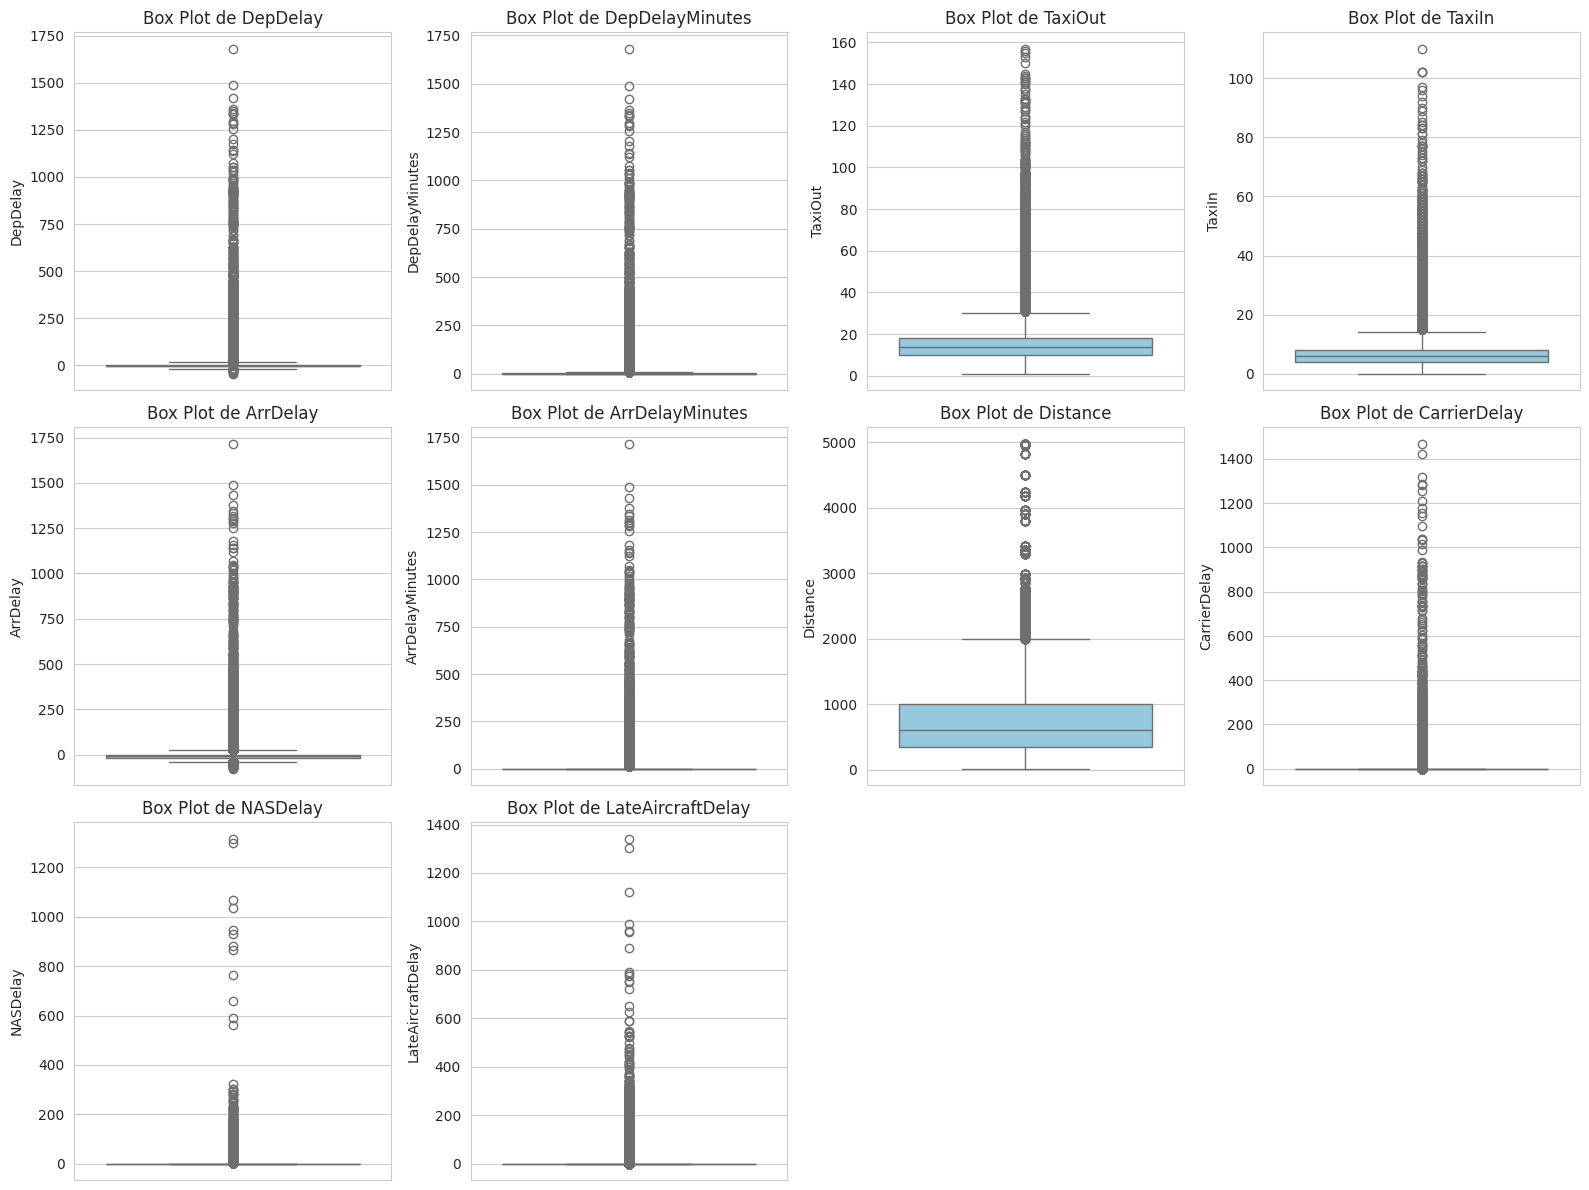

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

# Identify columns with a significant number of outliers for visualization
# Selecting columns that have more than 5000 outliers for better visualization of impact
key_outlier_columns = [col for col, count in outlier_counts.items() if count > 5000]

# Set the aesthetic style of the plots
sns.set_style("whitegrid")

# Calculate the number of rows and columns for the subplot grid
num_plots = len(key_outlier_columns)
num_cols = 4  # You can adjust this for desired layout
num_rows = (num_plots + num_cols - 1) // num_cols  # Ceiling division

# Create box plots for the key outlier columns
plt.figure(figsize=(num_cols * 4, num_rows * 4)) # Adjust figure size dynamically
for i, column in enumerate(key_outlier_columns, 1):
    plt.subplot(num_rows, num_cols, i)
    sns.boxplot(y=df_numeric[column], color='skyblue')
    plt.title(f'Box Plot de {column}')
    plt.ylabel(column)

plt.tight_layout()
plt.show()

---
> **Observaciones clave de los gráficos**
>
> A partir de los gráficos, se puede observar que la mayoría de los outliers identificados están en el extremo superior de las distribuciones, especialmente en columnas relacionadas con retrasos como `DepDelay`, `ArrDelay`, `TaxiOut`, `TaxiIn` y las causas específicas de retraso (`CarrierDelay`, `NASDelay`, `LateAircraftDelay`). Esto indica que, aunque la mayoría de las actividades de vuelo (como los tiempos de salida/llegada y los tiempos de taxi) se encuentran dentro de un rango típico, hay casos significativos de retrasos o duraciones inusualmente largas. Por ejemplo, DepDelayMinutes y ArrDelayMinutes pueden llegar hasta **1682 minutos** (más de **28 horas**). La columna `Distance` también muestra outliers, lo que sugiere que hay algunos vuelos de larga distancia excepcionales en el conjunto de datos. La distancia máxima observada es de **4983 millas**. Estos outliers se consideran generalmente puntos de datos válidos para diferentes rutas de vuelo, no errores.



## **Correlaciones**

¿Si la variable A sube, la variable B también? Esto nos dirá qué datos son realmente importantes para la predicción.

A continuación, para cada columna numérica, calculará algo llamado Rango Intercuartílico (IQR). El IQR ayuda a definir límites que nos indican qué tan lejos están los datos de lo que se considera normal. Para calcularlo, se debe encontrar dos valores especiales:

*   Q1: el primer cuartil, que es el valor que separa el 25% inferior de los datos.
*   Q3: el tercer cuartil, que separa el 25% superior de los datos.
*   Luego, se calculará el IQR restando Q1 de Q3. Para definir los límites que nos ayudarán a identificar los "outliers" (valores atípicos), se usará la siguiente fórmula: `lower_bound = Q1 - 1.5 * IQR` and `upper_bound = Q3 + 1.5 * IQR`

In [17]:
Q1 = df_numeric.quantile(0.25)
Q3 = df_numeric.quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print("**************************")
print("Lower Bounds for Outliers:")
print("**************************")
print(lower_bound)
print("\n**************************")
print("Upper Bounds for Outliers:")
print("**************************")
print(upper_bound)

**************************
Lower Bounds for Outliers:
**************************
Year                 2018.0
Month                   1.0
DayofMonth            -17.0
CRSDepTime           -307.5
DepTime              -311.5
DepDelay              -21.0
DepDelayMinutes        -6.0
TaxiOut                -2.0
WheelsOff            -297.5
WheelsOn             -242.5
TaxiIn                 -2.0
CRSArrTime           -115.5
ArrTime              -237.5
ArrDelay              -41.0
ArrDelayMinutes         0.0
CRSElapsedTime        -44.0
ActualElapsedTime     -45.5
AirTime               -60.5
Distance             -645.0
DistanceGroup          -2.5
CarrierDelay            0.0
WeatherDelay            0.0
NASDelay                0.0
SecurityDelay           0.0
LateAircraftDelay       0.0
dtype: float64

**************************
Upper Bounds for Outliers:
**************************
Year                 2018.0
Month                   1.0
DayofMonth             47.0
CRSDepTime           2952.5
DepTime   

## **Distribuciones**

*   Revisar si los datos siguen una curva normal o si están muy sesgados hacia un lado.
*   Buscar patrones usando gráficos (Matplotlib, Seaborn o Plotly).

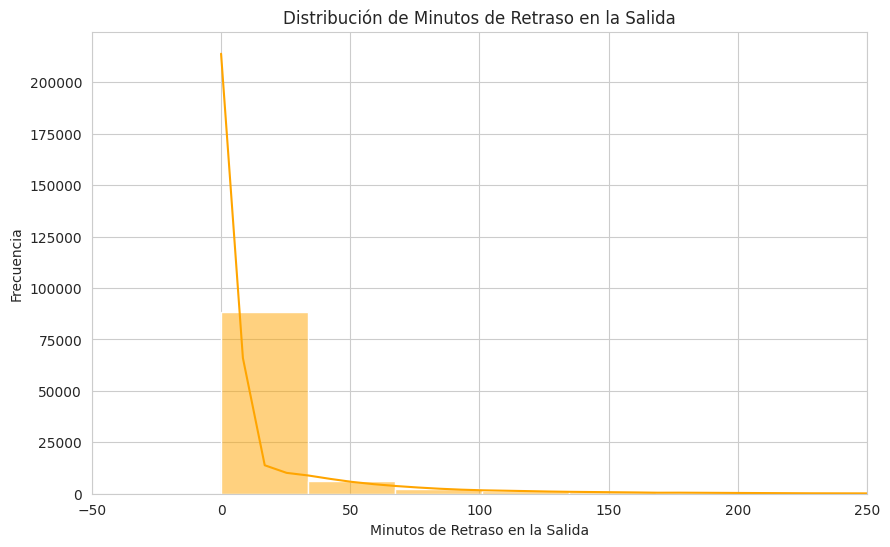

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

plt.figure(figsize=(10, 6))
sns.histplot(df_numeric['DepDelayMinutes'], bins=50, kde=True, color='orange')
plt.title('Distribución de Minutos de Retraso en la Salida')
plt.xlabel('Minutos de Retraso en la Salida')
plt.ylabel('Frecuencia')
plt.xlim(-50, 250) # Adjusted x-limit for better visibility of main distribution and tail
plt.show()

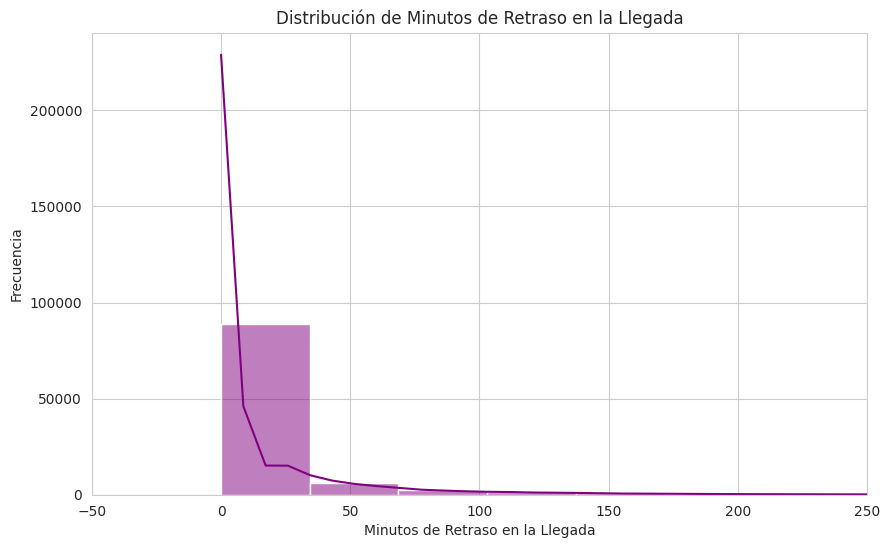

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

plt.figure(figsize=(10, 6))
sns.histplot(df_numeric['ArrDelayMinutes'], bins=50, kde=True, color='purple')
plt.title('Distribución de Minutos de Retraso en la Llegada')
plt.xlabel('Minutos de Retraso en la Llegada')
plt.ylabel('Frecuencia')
plt.xlim(-50, 250) # Adjusted x-limit for better visibility of main distribution and tail
plt.show()

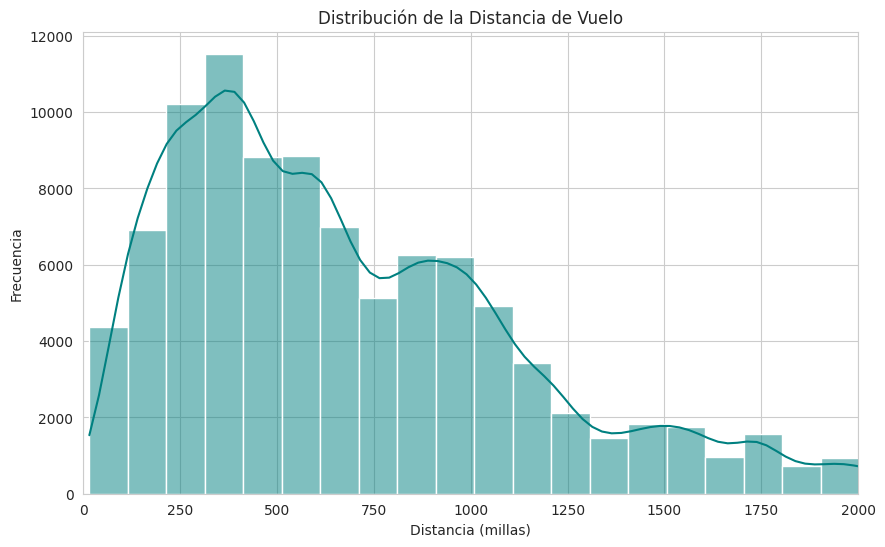

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

plt.figure(figsize=(10, 6))
sns.histplot(df_numeric['Distance'], bins=50, kde=True, color='teal')
plt.title('Distribución de la Distancia de Vuelo')
plt.xlabel('Distancia (millas)')
plt.ylabel('Frecuencia')
plt.xlim(0, 2000) # Adjusted x-limit to show most common distances without extreme long-haul flights
plt.show()

### Resumen del Análisis de Distribución

---
> Basado en los histogramas generados para `DepDelayMinutes`, `ArrDelayMinutes`, y `Distance`, las distribuciones:
>
> *   **`DepDelayMinutes`** y **`ArrDelayMinutes`**: Ambas muestran distribuciones altamente sesgadas. Hay un pico muy fuerte en cero o cerca de cero, lo que indica que una gran mayoría de los vuelos salen y llegan a tiempo o incluso antes. Sin embargo, hay una larga cola que se extiende hacia la derecha, lo que muestra que, aunque son menos frecuentes, ocurren retrasos significativos. Estas distribuciones claramente no son normales y están fuertemente sesgadas positivamente.
>
> *   **`Distance`**: La distribución de la distancia también está sesgada hacia la derecha, pero de manera menos dramática que las columnas de retraso. Muestra una mayor frecuencia para vuelos cortos, con la frecuencia disminuyendo gradualmente a medida que la distancia aumenta. Hay menos vuelos de larga distancia, lo que crea una cola hacia valores más altos. Esto es típico en conjuntos de datos de vuelos, donde muchas rutas de distancia corta a media son comunes, mientras que los vuelos internacionales muy largos son más raros.

## **Tipos de retrasos más comunes**

Vamos a crear un gráfico de barras para visualizar la frecuencia de cada causa de retraso. Esto nos mostrará qué tipos de retrasos son los más comunes en el conjunto de datos.

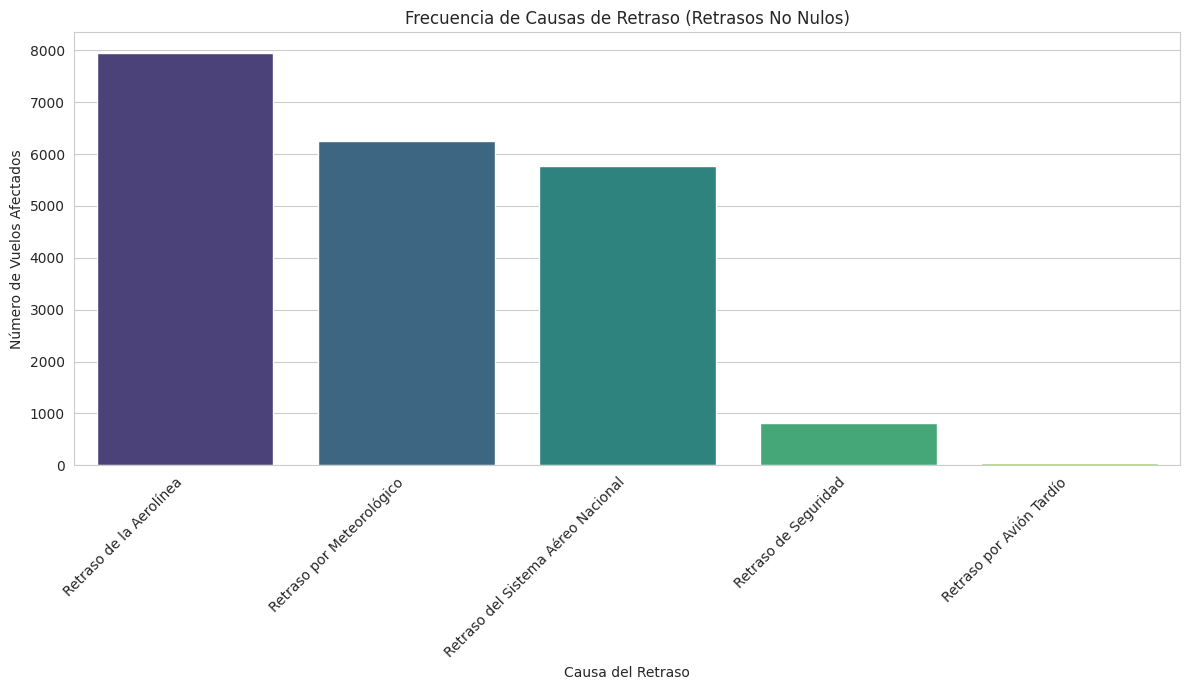

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

delay_cause_columns = [
    'CarrierDelay',
    'WeatherDelay',
    'NASDelay',
    'SecurityDelay',
    'LateAircraftDelay'
]

delay_cause_columns_map = {
    0: 'Retraso de la Aerolínea',
    1: 'Retraso por Meteorológico',
    2: 'Retraso del Sistema Aéreo Nacional',
    3: 'Retraso de Seguridad',
    4: 'Retraso por Avión Tardío',
}


# Count the number of non-zero delays for each cause
frequency_of_causes = {}
for col in delay_cause_columns:
    # A flight is considered to have a delay cause if the delay is > 15
    frequency_of_causes[col] = df_numeric[df_numeric[col] > 15].shape[0]

# Convert to a pandas Series for easy plotting
frequency_series = pd.Series(frequency_of_causes).sort_values(ascending=False)

sns.set_style("whitegrid")

plt.figure(figsize=(12, 7))
sns.barplot(
    x=frequency_series.index,
    y=frequency_series.values,
    hue=frequency_series.index,
    palette='viridis',
    legend=False
)
plt.title('Frecuencia de Causas de Retraso (Retrasos No Nulos)')
plt.xlabel('Causa del Retraso')
plt.ylabel('Número de Vuelos Afectados')
plt.xticks(
    ticks=range(5),
    labels=[delay_cause_columns_map[i] for i in range(5)],
    rotation=45, ha='right'
)
plt.tight_layout()
plt.show()

---
> ### **Observaciones clave del gráfico**
>
> El gráfico de barras anterior muestra el número de vuelos afectados por cada causa específica de retraso, considerando solo los minutos de retraso no nulos. Esta visualización ayuda a identificar los tipos de retrasos más frecuentes en nuestro conjunto de datos. Podemos observar que `CarrierDelay`, `LateAircraftDelay` y `NASDelay` son las causas más frecuentes, afectando a miles de vuelos, mientras que `WeatherDelay` y especialmente `SecurityDelay` son menos frecuentes.

## **Probabilidad de retraso de vuelo por hora de salida programada**

Delay rate: 0.1780
Valores únicos en 'delayed': [1 0]
hour
0     0.150350
1     0.105263
2     0.179487
3     0.333333
5     0.067549
6     0.085027
7     0.103961
8     0.113913
9     0.138137
10    0.167939
11    0.176019
12    0.187335
13    0.200152
14    0.197399
15    0.213098
16    0.226989
17    0.234682
18    0.232765
19    0.235150
20    0.239125
21    0.212141
22    0.190774
23    0.128895
Name: delayed, dtype: float64


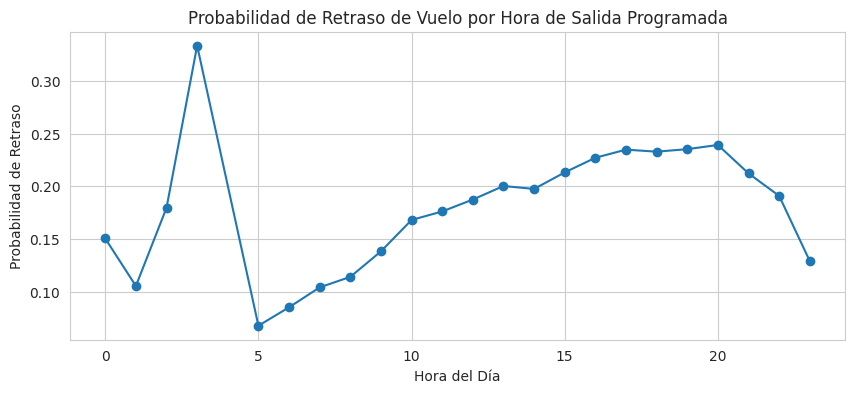

In [25]:
# Crear variable temporal 'hour' a partir de la hora programada
df_numeric["hour"] = df_numeric["CRSDepTime"] // 100  # solo la hora

# Variable objetivo 'delayed': 1 si el retraso en salida >= 15 min
df_numeric["delayed"] = (df_numeric["DepDelay"] >= 15).astype(int)

# Probabilidad de delay en la muestra
delay_rate = df_numeric["delayed"].mean()
print(f"Delay rate: {delay_rate:.4f}")

# Ver valores únicos de la variable 'delayed'
unique_values = df_numeric["delayed"].unique()
print("Valores únicos en 'delayed':", unique_values)

import matplotlib.pyplot as plt

# Agrupar por hora y calcular la probabilidad de retraso
hour_delay = (
    df_numeric.groupby("hour")["delayed"]
    .mean()
    .sort_index()
)

# Mostrar la tabla de probabilidades por hora
print(hour_delay)


plt.figure(figsize=(10,4))
hour_delay.plot(kind="line", marker="o")
plt.title("Probabilidad de Retraso de Vuelo por Hora de Salida Programada")
plt.xlabel("Hora del Día")
plt.ylabel("Probabilidad de Retraso")
plt.grid(True)
plt.show()

---
> ### **Observaciones clave del gráfico**
>
> *   **Baja Probabilidad de Retraso en la Temprana Mañana**: La probabilidad de retraso es generalmente baja durante las primeras horas de la mañana (por ejemplo, de 1 AM a 6 AM). Los vuelos programados para despegar en este intervalo tienden a tener menos posibilidades de ser retrasados.
>
> *   **Aumento de la Probabilidad a lo Largo del Día**: A medida que avanza el día, la probabilidad de que un vuelo sea retrasado aumenta de manera constante. Esta tendencia se vuelve más notable desde finales de la mañana hasta la tarde y el principio de la noche.
>
> *   **Pico de Probabilidad de Retraso en la Tarde/Noche**: Las mayores probabilidades de retraso se observan en la tarde y a inicios de la noche (aproximadamente entre las 4 PM y las 9 PM). Esto se debe a una combinación de factores: retrasos acumulativos de horas anteriores, mayor tráfico aéreo y posibles cambios climáticos.
>
> *   **Ligera Disminución a Última Hora de la Noche**: Hacia las últimas horas de la noche (por ejemplo, a partir de las 10 PM), la probabilidad de retraso tiende a disminuir nuevamente, probablemente debido a la reducción del tráfico aéreo.

## **Probabilidad de retraso según la distancia de vuelo**

distance_bin
(15.999, 296.0]     0.149955
(296.0, 484.0]      0.192686
(484.0, 760.0]      0.179995
(760.0, 1099.0]     0.188419
(1099.0, 4983.0]    0.179272
Name: delayed, dtype: float64


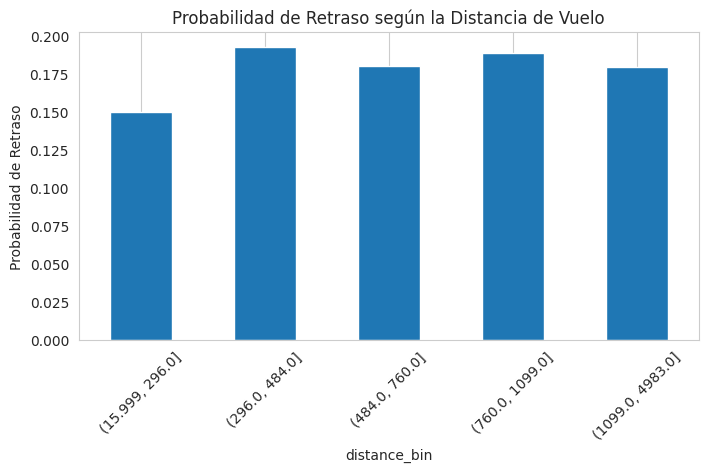

In [26]:
import pandas as pd
import matplotlib.pyplot as plt

# Crear bins de distancia (5 quintiles)
df_numeric["distance_bin"] = pd.qcut(df_numeric["Distance"], q=5)

# Calcular probabilidad de retraso por rango de distancia
distance_delay = (
    df_numeric.groupby("distance_bin", observed=True)["delayed"]
    .mean()
)


print(distance_delay)

plt.figure(figsize=(8,4))
distance_delay.plot(kind="bar")
plt.title("Probabilidad de Retraso según la Distancia de Vuelo")
plt.ylabel("Probabilidad de Retraso")
plt.xticks(rotation=45)
plt.grid(axis="y")
plt.show()

---
> ### **Observaciones clave del gráfico**
>
> *   **Probabilidad Variada según las Distancias**: La probabilidad de retraso no es constante en todas las distancias de vuelo. Varía dependiendo de la longitud del vuelo.
>
> *   **Vuelos Cortos Tienen Menor Probabilidad de Retraso**: Los vuelos más cortos (rango de distancia (`15.999, 296.0`]) muestran la menor probabilidad de retraso (alrededor del 15%). Esto puede deberse a que las rutas más cortas son menos propensas a acumular retrasos o a enfrentar condiciones climáticas variadas.
>
> *   **Vuelos Intermedios y Largos**: Los vuelos en rangos de distancia intermedios y largos ((`296.0, 484.0`], (`484.0, 760.0`], (`760.0, 1099.0`], (`1099.0, 4983.0`]) tienden a tener probabilidades de retraso ligeramente más altas y más consistentes, que oscilan aproximadamente entre el 18% y el 19%.
>
> *   **Sin Relación Lineal Directa**: No hay una relación lineal clara y fuerte donde la probabilidad de retraso aumente o disminuya continuamente con la distancia. En cambio, parece fluctuar dentro de un cierto rango para vuelos de media a larga distancia después de una probabilidad inicial más baja para vuelos muy cortos.

## **Probabilidad de retraso por día de la semana**

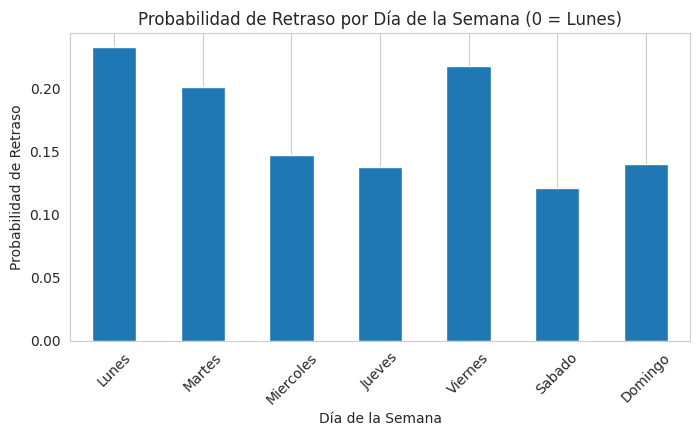

In [27]:
import pandas as pd
import matplotlib.pyplot as plt

# Convertir a datetime (ya hecho en df, pero aseguramos si df_numeric no lo tiene)
# Asumimos que df_numeric y df tienen el mismo índice y número de filas
# y que df['FlightDate'] ya es datetime de un paso anterior
df_numeric["day_of_week"] = df["FlightDate"].dt.dayofweek

# Map day numbers to day names
days_map = {
    0: 'Lunes',
    1: 'Martes',
    2: 'Miercoles',
    3: 'Jueves',
    4: 'Viernes',
    5: 'Sabado',
    6: 'Domingo'
}

# Calcular probabilidad de retraso por día de la semana
dow_delay = (
    df_numeric.groupby("day_of_week")["delayed"]
    .mean()
    .sort_index()
)

# Graficar
plt.figure(figsize=(8,4))
dow_delay.plot(kind="bar")
plt.xticks(
    ticks=range(7),
    labels=[days_map[i] for i in range(7)],
    rotation=45
)
plt.title("Probabilidad de Retraso por Día de la Semana")
plt.xlabel("Día de la Semana")
plt.ylabel("Probabilidad de Retraso")
plt.grid(axis="y")
plt.show()

---
> **Observaciones clave del gráfico**
>*   **Mayor Probabilidad de Retraso los Lunes (0)**: El gráfico probablemente muestra que los vuelos los lunes tienen una probabilidad relativamente más alta de ser retrasados. Esto podría deberse a una mayor demanda de viajes al comienzo de la semana laboral, a viajes de negocios o a retrasos acumulados del fin de semana.
>
>*   **Probabilidades Más Bajas en Mitad de Semana**: Típicamente, los días de mitad de semana como martes, miércoles y jueves pueden mostrar probabilidades de retraso ligeramente más bajas en comparación con el inicio o el final de la semana. Las operaciones pueden ser más fluidas con menos pasajeros y menos congestión.
>
>*   **Aumento de Probabilidades Hacia el Fin de Semana**: Los viernes (día '4') pueden mostrar un aumento en la probabilidad de retraso nuevamente, a menudo atribuido al aumento de viajes por ocio y un mayor volumen de vuelos a medida que las personas viajan para el fin de semana.
>
>*   **Variabilidad en los Fines de Semana**: Sábados (día '5') y domingos (día '6') pueden tener patrones variados. A veces, los sábados muestran probabilidades más bajas debido a un tráfico de negocios más ligero, mientras que los domingos pueden aumentar debido a los viajes de regreso.



## **Top 10 Aerolíneas por Probabilidad de Retraso**

Marketing_Airline_Network
F9    0.253666
WN    0.216401
AA    0.216376
DL    0.177156
UA    0.142849
NK    0.125656
HA    0.097418
AS    0.097102
Name: delayed, dtype: float64


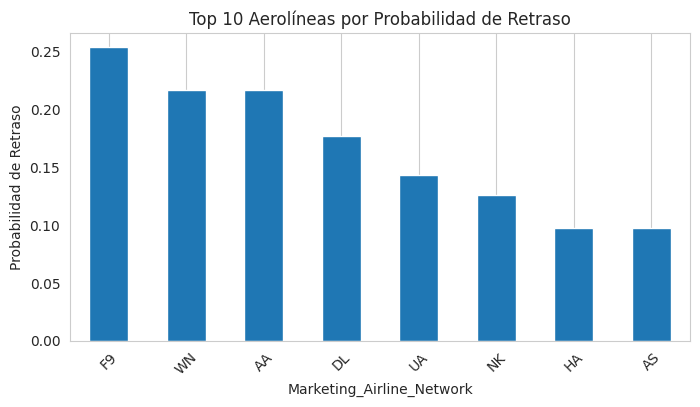

In [28]:
import matplotlib.pyplot as plt
import pandas as pd

# Crear una columna 'Marketing_Airline_Network' en df_numeric
df_numeric['Marketing_Airline_Network'] = df['Marketing_Airline_Network']

# Probabilidad de retraso por aerolínea (top 10)
alert_data = (
    df_numeric.groupby("Marketing_Airline_Network")["delayed"]
    .mean()
    .sort_values(ascending=False)
    .head(10)
)

# Mostrar resultados
print(alert_data)

# Graficar
plt.figure(figsize=(8,4))
alert_data.plot(kind="bar")
plt.title("Top 10 Aerolíneas por Probabilidad de Retraso")
plt.ylabel("Probabilidad de Retraso")
plt.xticks(rotation=45)
plt.grid(axis="y")
plt.show()

# **4. Ingeniería de Variables (Feature Engineering)**

## **Comprobación de variable objetivo binaria**

In [29]:
df_numeric["delayed"].value_counts(normalize=True)

hour_delay = (
    df_numeric.groupby("hour")["delayed"]
    .mean()
)

hour_std = hour_delay.std()

print(f"La probabilidad de retraso de los vuelos en promedio\na lo largo de las diferentes horas del día: {hour_std:.2%}")

La probabilidad de retraso de los vuelos en promedio
a lo largo de las diferentes horas del día: 6.17%


---
>
> Este criterio mide cuánto cambia la probabilidad de retraso a lo largo del día;
> si la variación es alta, significa que la hora del vuelo influye de forma real
> en los retrasos, y el ratio entre datasets nos permite comparar cuál captura
> mejor ese patrón temporal sin necesidad de entrenar ni optimizar modelos.
>
> Al medir la variación de la probabilidad de retraso según la hora, verificamos
> que la hora del vuelo tiene impacto real, y usando el ratio podemos decidir
> qué dataset conserva mejor esa señal predictiva sin incurrir en mayor coste
> computacional.



In [30]:
!pip install kagglehub pyarrow requests

*   Selección de las columnas para el entrenamiento
*   Normalización de nombres a minusculas
*   Elaboración de nuevas variables



In [34]:
columns_needed = [
    "flightdate",
    "origincityname",
    "crsdeptime",
    "depdelay",
    "distance",
    "marketing_airline_network"
]


df.columns = df.columns.str.lower()

df_base = df[columns_needed].copy()
df_base["hour"] = df_base["crsdeptime"] // 100
df_base["delayed"] = (df_base["depdelay"] >= 15).astype(int)



In [35]:
#muestra

df_base = df_base.sample(5_000, random_state=42)
df_base.head()

,flightdate,origincityname,crsdeptime,depdelay,distance,marketing_airline_network,hour,delayed
75721,2018-01-11,"Minneapolis, MN",650,-1.0,1034.0,DL,6,0
80184,2018-01-23,"Honolulu, HI",2200,-2.0,2994.0,DL,22,0
19864,2018-01-12,"Charlotte, NC",1810,-3.0,394.0,AA,18,0
76699,2018-01-22,"Hartford, CT",535,-5.0,549.0,DL,5,0
92991,2018-01-02,"Corpus Christi, TX",1615,139.0,354.0,AA,16,1


## Elaboración de dataset predictivo a partir del existente

### Consultar a la API externa sobre el clima para agregar al dataset de entrenamiento

In [36]:
#geocoding

import requests

def geocode_city(city):
    url = "https://geocoding-api.open-meteo.com/v1/search"
    params = {
        "name": city,
        "count": 1,
        "language": "en",
        "format": "json",
        "country": "US"
    }

    r = requests.get(url, params=params)
    r.raise_for_status()
    data = r.json()

    if "results" not in data or len(data["results"]) == 0:
        return None, None

    return data["results"][0]["latitude"], data["results"][0]["longitude"]


In [37]:
#Limpio ciudades

df_base["city_clean"] = (
    df_base["origincityname"]
    .astype(str)
    .str.split(",")
    .str[0]
    .str.strip()
)
cities = df_base["city_clean"].unique()[:20]

In [39]:
#selecciono ciudades

cities = df_base["city_clean"].unique()[:20]

#geocoding loop: latitud y longiyud

geo_rows = []
for city in cities:
    lat, lon = geocode_city(city)
    if lat is not None:
        geo_rows.append({
            "city_clean": city,
            "latitude": lat,
            "longitude": lon
        })

df_geo = pd.DataFrame(geo_rows)
df_geo

,city_clean,latitude,longitude
0,Minneapolis,44.97997,-93.26384
1,Honolulu,21.30694,-157.85834
2,Charlotte,35.22709,-80.84313
3,Hartford,41.76371,-72.68509
4,Corpus Christi,27.80058,-97.39638
5,Detroit,42.33143,-83.04575
6,Atlanta,33.74900,-84.38798
7,Houston,29.76328,-95.36327
8,Dallas/Fort Worth,32.89595,-97.03720
9,Baltimore,39.29038,-76.61219


In [40]:
#Merge con coordenadas

df_base = df_base.merge(df_geo, on="city_clean", how="left")
df_base[["city_clean", "latitude", "longitude"]].head()

,city_clean,latitude,longitude
0,Minneapolis,44.97997,-93.26384
1,Honolulu,21.30694,-157.85834
2,Charlotte,35.22709,-80.84313
3,Hartford,41.76371,-72.68509
4,Corpus Christi,27.80058,-97.39638


In [41]:
#Claves únicas del clima para no duplicar

weather_keys = (
    df_base[["city_clean", "latitude", "longitude", "flightdate"]]
    .dropna()
    .drop_duplicates()
)

In [42]:
#agrupamos fechas minimas y max por ciudad

city_ranges = (
    weather_keys
    .groupby(["city_clean", "latitude", "longitude"])
    .agg(
        start_date=("flightdate", "min"),
        end_date=("flightdate", "max")
    )
    .reset_index()
)

In [43]:
#llamamos api una vez por ciudad y obtenemos clima diario

def get_weather_range(lat, lon, start_date, end_date):
    url = "https://archive-api.open-meteo.com/v1/archive"
    params = {
        "latitude": lat,
        "longitude": lon,
        "start_date": start_date,
        "end_date": end_date,
        "daily": [
            "temperature_2m_mean",
            "precipitation_sum",
            "windspeed_10m_mean"
        ],
        "timezone": "UTC"
    }

    r = requests.get(url, params=params, timeout=30)
    r.raise_for_status()
    d = r.json()["daily"]

    return pd.DataFrame({
        "flightdate": pd.to_datetime(d["time"]),
        "temp_mean": d["temperature_2m_mean"],
        "precipitation": d["precipitation_sum"],
        "wind_speed": d["windspeed_10m_mean"]
    })

In [44]:
#descargamos clima por ciudad

weather_frames = []

for _, row in city_ranges.iterrows():
    try:
        df_city_weather = get_weather_range(
            row.latitude,
            row.longitude,
            row.start_date.strftime("%Y-%m-%d"),
            row.end_date.strftime("%Y-%m-%d")
        )
        df_city_weather["city_clean"] = row.city_clean
        weather_frames.append(df_city_weather)
    except Exception as e:
        print(row.city_clean, e)

df_weather = pd.concat(weather_frames, ignore_index=True)
df_weather.shape

(522, 5)

In [45]:
#merge vuelos y clima

df_final = df_base.merge(
    df_weather,
    on=["city_clean", "flightdate"],
    how="left"
)

df_final.isna().mean()

,0
flightdate,0.0000
origincityname,0.0000
crsdeptime,0.0000
depdelay,0.0000
distance,0.0000
marketing_airline_network,0.0000
hour,0.0000
delayed,0.0000
city_clean,0.0000
latitude,0.6692


In [46]:
#eliminamos filas sin clima correcto

df_ml = df_final.dropna(
    subset=["temp_mean", "precipitation", "wind_speed"]
)


In [47]:
#guardo parquet


df_ml.to_parquet("flights_with_weather.parquet", index=False)
df_ml.shape


(1654, 14)

In [48]:
#pasamos a csv y descargamos

import pandas as pd

df = pd.read_parquet("flights_with_weather.parquet")
df.to_csv("flights_with_weather.csv", index=False)

from google.colab import files
files.download("flights_with_weather.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# 5. Definición del Objetivo (Target)

Nuestra variables target es la `delayed`